In [1]:
import rasterio
from rasterio.crs import CRS
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
from tqdm import tqdm
from boto3.s3.transfer import TransferConfig

# Generate tiles

We are going to use the Hansen et al. data found [here](https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/download.html). For actual products, this would likely be Planet data or some high resolution map that we would need for classification.

In [2]:
# box inputs are minx, miny, maxx, maxy
geometries = [box(-180 + i * 10, 
                  80 - (j + 1) * 10, 
                  -180 + (i + 1) * 10,
                  80 - (j) * 10) for i in range(36) for j in range(16)]

# Upper left corner
ul_corners = [(-180 + (i) * 10, 80 - (j) * 10) for i in range(36) for j in range(16)]
df_hansen_tiles = gpd.GeoDataFrame(geometry=geometries, crs=CRS.from_epsg(4326))

Let's see the tiles.

<AxesSubplot:>

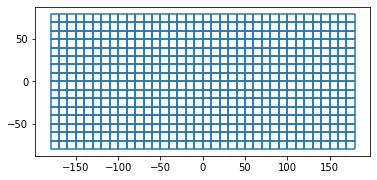

In [3]:
df_hansen_tiles.exterior.plot()

In [4]:
def url_generator(corner: tuple, 
                  layer: str ='last'):
    
    assert(layer in ['first', 'last', 'treecover2000'])
    
    base_url = 'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8'
    lon, lat = corner
    if lon < 0:
        lon_str = f'{abs(lon):03d}W'
    else:
        lon_str = f'{abs(lon):03d}E'
    if lat >= 0:
        lat_str = f'{abs(lat):02d}N'
    else:
        lat_str = f'{abs(lat):02d}S'
    return f'{base_url}/Hansen_GFC-2020-v1.8_last_{lat_str}_{lon_str}.tif'


In [5]:
df_hansen_tiles['source_url'] = list(map(url_generator, ul_corners))
df_hansen_tiles['year'] = 2020
df_hansen_tiles['bucket'] = 'test-prod--hansen-landsat-mosaics-2020'
df_hansen_tiles['key'] = df_hansen_tiles.source_url.map(lambda x: x.split('/')[-1])

df_hansen_tiles.head()

,geometry,source_url,year,bucket,key
0,"POLYGON ((-170.00000 70.00000, -170.00000 80.0...",https://storage.googleapis.com/earthenginepart...,2020,test-prod--hansen-landsat-mosaics-2020,Hansen_GFC-2020-v1.8_last_80N_180W.tif
1,"POLYGON ((-170.00000 60.00000, -170.00000 70.0...",https://storage.googleapis.com/earthenginepart...,2020,test-prod--hansen-landsat-mosaics-2020,Hansen_GFC-2020-v1.8_last_70N_180W.tif
2,"POLYGON ((-170.00000 50.00000, -170.00000 60.0...",https://storage.googleapis.com/earthenginepart...,2020,test-prod--hansen-landsat-mosaics-2020,Hansen_GFC-2020-v1.8_last_60N_180W.tif
3,"POLYGON ((-170.00000 40.00000, -170.00000 50.0...",https://storage.googleapis.com/earthenginepart...,2020,test-prod--hansen-landsat-mosaics-2020,Hansen_GFC-2020-v1.8_last_50N_180W.tif
4,"POLYGON ((-170.00000 30.00000, -170.00000 40.0...",https://storage.googleapis.com/earthenginepart...,2020,test-prod--hansen-landsat-mosaics-2020,Hansen_GFC-2020-v1.8_last_40N_180W.tif


Let's read the bounds from the URLs and make sure they match.

In [6]:
url = df_hansen_tiles.source_url[0]
with rasterio.open(url) as ds:
    print(ds.bounds)
    print(url)

BoundingBox(left=-180.0001388888889, bottom=69.9998611111111, right=-169.99986111111113, top=80.00013888888888)
https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/Hansen_GFC-2020-v1.8_last_80N_180W.tif


# Get Tiles over AOIs

In [7]:
aois = gpd.read_file('aois.geojson')
aois_geo = aois.geometry.unary_union

<AxesSubplot:>

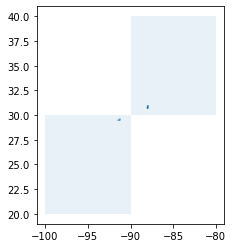

In [8]:
fig, ax = plt.subplots()

df_hansen_deltas = df_hansen_tiles[df_hansen_tiles.geometry.intersects(aois_geo)].reset_index(drop=True)

df_hansen_deltas.plot(ax = ax, alpha=.1)
aois.plot(ax=ax)

In [9]:
df_hansen_deltas

,geometry,source_url,year,bucket,key
0,"POLYGON ((-90.00000 20.00000, -90.00000 30.000...",https://storage.googleapis.com/earthenginepart...,2020,test-prod--hansen-landsat-mosaics-2020,Hansen_GFC-2020-v1.8_last_30N_100W.tif
1,"POLYGON ((-80.00000 30.00000, -80.00000 40.000...",https://storage.googleapis.com/earthenginepart...,2020,test-prod--hansen-landsat-mosaics-2020,Hansen_GFC-2020-v1.8_last_40N_090W.tif


In [10]:
df_hansen_deltas.source_url.tolist()

['https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/Hansen_GFC-2020-v1.8_last_30N_100W.tif',
 'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/Hansen_GFC-2020-v1.8_last_40N_090W.tif']

# Upload Tile Index to s3

References from Stackoverflow:
+ [How to connect to s3](https://stackoverflow.com/a/40336919) - there are two ways
+ [Upload json to s3](https://stackoverflow.com/a/53004085)

In [11]:
geojson_bytes = bytes(df_hansen_deltas.to_json(drop_id=True).encode('UTF-8'))
geojson_bytes

b'{"type": "FeatureCollection", "features": [{"type": "Feature", "properties": {"bucket": "test-prod--hansen-landsat-mosaics-2020", "key": "Hansen_GFC-2020-v1.8_last_30N_100W.tif", "source_url": "https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/Hansen_GFC-2020-v1.8_last_30N_100W.tif", "year": 2020}, "geometry": {"type": "Polygon", "coordinates": [[[-90.0, 20.0], [-90.0, 30.0], [-100.0, 30.0], [-100.0, 20.0], [-90.0, 20.0]]]}}, {"type": "Feature", "properties": {"bucket": "test-prod--hansen-landsat-mosaics-2020", "key": "Hansen_GFC-2020-v1.8_last_40N_090W.tif", "source_url": "https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/Hansen_GFC-2020-v1.8_last_40N_090W.tif", "year": 2020}, "geometry": {"type": "Polygon", "coordinates": [[[-80.0, 30.0], [-80.0, 40.0], [-90.0, 40.0], [-90.0, 30.0], [-80.0, 30.0]]]}}]}'

In [12]:
import boto3

session = boto3.session.Session(profile_name='saml-pub')

s3 = session.resource('s3')

geojson_bucket = 'calval-metadata'
geojson_key = f'{df_hansen_deltas.bucket[0]}.geojson'

s3object = s3.Object(geojson_bucket, geojson_key)
s3object.put(Body=geojson_bytes)

{'ResponseMetadata': {'RequestId': 'PBNT0F99CRCXFCZ9',
  'HostId': 'SYluWlP7VVI9/c8ee/aCp1ncYusv47zHCfMXT9atI1EGDXbMBkx+nqqi0zjxwFRud7a2Zpd7SPY=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'SYluWlP7VVI9/c8ee/aCp1ncYusv47zHCfMXT9atI1EGDXbMBkx+nqqi0zjxwFRud7a2Zpd7SPY=',
   'x-amz-request-id': 'PBNT0F99CRCXFCZ9',
   'date': 'Wed, 29 Dec 2021 18:26:56 GMT',
   'etag': '"998aec653be81f945102812bf9de1162"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"998aec653be81f945102812bf9de1162"'}

In [13]:
df_hansen_deltas.to_file(geojson_key, driver='GeoJSON')

# Read Geojson on S3

Show existing buckets

In [14]:
buckets = list(s3.buckets.all())
buckets

[s3.Bucket(name='calval-metadata'),
 s3.Bucket(name='test-prod--hansen-landsat-mosaics-2020')]

Let's inspect the bucket contents.

In [15]:
metadata_bucket = s3.Bucket('calval-metadata')
list(metadata_bucket.objects.all())

[s3.ObjectSummary(bucket_name='calval-metadata', key='TEST-PROD.hansen-landsat-mosaics-2020.geojson'),
 s3.ObjectSummary(bucket_name='calval-metadata', key='TEST-PROD_hansen-landsat-mosaics-2020.geojson'),
 s3.ObjectSummary(bucket_name='calval-metadata', key='test-hansen-landsat.geojson'),
 s3.ObjectSummary(bucket_name='calval-metadata', key='test-prod--hansen-landsat-mosaics-2020.geojson'),
 s3.ObjectSummary(bucket_name='calval-metadata', key='test-prod--test-prod--cropped-hansen-landsat-mosaics-2020.geojson'),
 s3.ObjectSummary(bucket_name='calval-metadata', key='test-prod_hansen-landsat-mosaics-2020.geojson')]

Read the actual dataframe.

In [16]:
obj = s3.Object(geojson_bucket, geojson_key)
obj.get()

{'ResponseMetadata': {'RequestId': 'E3PVR4MTYQTG1HXA',
  'HostId': 'dbCbucsbwniU10/C37qH4dBC2n3YiJmyv+IwOlszRMfYYC7eAuX/ZOgsgNW4awWpc0zvtmh5oCM=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'dbCbucsbwniU10/C37qH4dBC2n3YiJmyv+IwOlszRMfYYC7eAuX/ZOgsgNW4awWpc0zvtmh5oCM=',
   'x-amz-request-id': 'E3PVR4MTYQTG1HXA',
   'date': 'Wed, 29 Dec 2021 18:26:57 GMT',
   'last-modified': 'Wed, 29 Dec 2021 18:26:56 GMT',
   'etag': '"998aec653be81f945102812bf9de1162"',
   'accept-ranges': 'bytes',
   'content-type': 'binary/octet-stream',
   'server': 'AmazonS3',
   'content-length': '859'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2021, 12, 29, 18, 26, 56, tzinfo=tzutc()),
 'ContentLength': 859,
 'ETag': '"998aec653be81f945102812bf9de1162"',
 'ContentType': 'binary/octet-stream',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7f3410b41f90>}

In [17]:
data = obj.get()['Body']
gpd.read_file(data)

,bucket,key,source_url,year,geometry
0,test-prod--hansen-landsat-mosaics-2020,Hansen_GFC-2020-v1.8_last_30N_100W.tif,https://storage.googleapis.com/earthenginepart...,2020,"POLYGON ((-90.00000 20.00000, -90.00000 30.000..."
1,test-prod--hansen-landsat-mosaics-2020,Hansen_GFC-2020-v1.8_last_40N_090W.tif,https://storage.googleapis.com/earthenginepart...,2020,"POLYGON ((-80.00000 30.00000, -80.00000 40.000..."


# Upload to Mosaics to s3 (this takes a *long* time on a local machine)

It's negligible on a fast server.

The buckets have to be unique globally - interesting that this is harder than it seems and will throw an [error](https://stackoverflow.com/q/57146311) like this.

Also, there are some constraints on bucket names as discussed in [here](https://stackoverflow.com/a/49548452).

In [18]:
buckets = list(s3.buckets.all())
buckets

[s3.Bucket(name='calval-metadata'),
 s3.Bucket(name='test-prod--hansen-landsat-mosaics-2020')]

In [19]:
bucket_name = df_hansen_deltas.bucket[0]
if bucket_name not in [b.name for b in buckets]:
    s3.Bucket(bucket_name).create(CreateBucketConfiguration={'LocationConstraint': 'us-west-2'})

In [20]:
records = df_hansen_deltas.to_dict('records')

In [21]:
record = records[0]

In [22]:
import requests

r = requests.get(record['source_url'], stream=True)
total_size = int(r.headers['Content-length'])
print( total_size / 1e9, 'GB')

5.022295203 GB


You need to use boto3 multipart upload; tqdm has a nice way to track upload as well.

Sources: 

1. Basic upload from s3 using public url: [link](https://stackoverflow.com/questions/14346065/upload-image-available-at-public-url-to-s3-using-boto)
2. Upload large file using TransferConfig and boto3: [link](https://stackoverflow.com/a/50118024) 
3. Getting tqdm to work with the above: [link](https://stackoverflow.com/a/70263266)
4. Doc on transferconfig: [link](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/customizations/s3.html#boto3.s3.transfer.TransferConfig)

In [23]:
def upload_one(record):
    
    r = requests.get(record['source_url'], stream=True)
    total_size = int(r.headers['Content-length'])

    bucket_name = record['bucket']
    key = record['key']
    config = TransferConfig(multipart_threshold=1024, 
                            max_concurrency=30,
                            # Commenting this out appears to make upload speed more variable
                            #multipart_chunksize=1024, 
                            use_threads=True)
    with tqdm(total=total_size,  
              unit='B', 
              unit_scale=True, 
              unit_divisor=1024) as pbar:


        bucket = s3.Bucket(bucket_name)
        resp = bucket.upload_fileobj(r.raw, key, Config=config, Callback=pbar.update)
    
    return resp

In [24]:
list(map(upload_one, tqdm(records[:])))

  0%|                                                               | 0/2 [00:00<?, ?it/s]
  0%|                                                         | 0.00/4.68G [00:00<?, ?B/s]
  0%|                                                | 256k/4.68G [00:00<1:44:03, 804kB/s]
  0%|                                                | 1.00M/4.68G [00:00<29:16, 2.86MB/s]
  0%|                                                | 7.00M/4.68G [00:00<04:06, 20.3MB/s]
  0%|▏                                               | 19.0M/4.68G [00:00<01:38, 51.0MB/s]
  1%|▍                                               | 39.8M/4.68G [00:00<00:49, 99.9MB/s]
  1%|▌                                                | 54.5M/4.68G [00:00<00:39, 124MB/s]
  1%|▌                                                | 54.5M/4.68G [00:00<00:39, 124MB/s]
  1%|▋                                                | 70.0M/4.68G [00:00<00:37, 134MB/s]
  1%|▋                                                | 70.2M/4.68G [00:00<00:35, 140MB/s]

 27%|█████████████▏                                   | 1.26G/4.68G [00:10<00:22, 163MB/s]
 27%|█████████████▍                                   | 1.28G/4.68G [00:10<00:23, 154MB/s]
 27%|█████████████▍                                   | 1.28G/4.68G [00:10<00:24, 148MB/s]
 28%|█████████████▌                                   | 1.30G/4.68G [00:10<00:22, 158MB/s]
 28%|█████████████▊                                   | 1.32G/4.68G [00:10<00:20, 179MB/s]
 29%|██████████████                                   | 1.34G/4.68G [00:10<00:21, 167MB/s]
 29%|██████████████▎                                  | 1.37G/4.68G [00:10<00:18, 198MB/s]
 30%|██████████████▌                                  | 1.38G/4.68G [00:11<00:20, 173MB/s]
 30%|██████████████▌                                  | 1.38G/4.68G [00:11<00:22, 158MB/s]
 30%|██████████████▋                                  | 1.40G/4.68G [00:11<00:21, 167MB/s]
 30%|██████████████▉                                  | 1.42G/4.68G [00:11<00:23, 151MB/s]

 57%|███████████████████████████▉                     | 2.66G/4.68G [00:20<00:18, 119MB/s]
 57%|███████████████████████████▎                    | 2.66G/4.68G [00:20<00:21, 99.5MB/s]
 57%|████████████████████████████                     | 2.68G/4.68G [00:21<00:19, 111MB/s]
 58%|████████████████████████████▏                    | 2.70G/4.68G [00:21<00:17, 122MB/s]
 58%|████████████████████████████▏                    | 2.70G/4.68G [00:21<00:16, 131MB/s]
 58%|███████████████████████████▉                    | 2.72G/4.68G [00:21<00:21, 97.4MB/s]
 59%|████████████████████████████▊                    | 2.75G/4.68G [00:21<00:18, 110MB/s]
 59%|████████████████████████████▉                    | 2.76G/4.68G [00:21<00:19, 108MB/s]
 59%|█████████████████████████████▏                   | 2.78G/4.68G [00:22<00:16, 120MB/s]
 60%|████████████████████████████▋                   | 2.79G/4.68G [00:22<00:20, 99.0MB/s]
 60%|█████████████████████████████▍                   | 2.81G/4.68G [00:22<00:18, 110MB/s]

 85%|█████████████████████████████████████████▌       | 3.97G/4.68G [00:32<00:05, 140MB/s]
 85%|█████████████████████████████████████████▋       | 3.98G/4.68G [00:32<00:05, 145MB/s]
 86%|█████████████████████████████████████████▉       | 4.00G/4.68G [00:32<00:05, 142MB/s]
 86%|██████████████████████████████████████████       | 4.01G/4.68G [00:32<00:04, 145MB/s]
 86%|██████████████████████████████████████████▏      | 4.03G/4.68G [00:32<00:05, 138MB/s]
 87%|██████████████████████████████████████████▍      | 4.06G/4.68G [00:32<00:03, 167MB/s]
 87%|██████████████████████████████████████████▋      | 4.07G/4.68G [00:33<00:06, 108MB/s]
 88%|██████████████████████████████████████████▉      | 4.09G/4.68G [00:33<00:04, 132MB/s]
 88%|███████████████████████████████████████████      | 4.11G/4.68G [00:33<00:05, 120MB/s]
 88%|██████████████████████████████████████████▍     | 4.13G/4.68G [00:33<00:05, 99.6MB/s]
 89%|███████████████████████████████████████████▋     | 4.16G/4.68G [00:33<00:05, 110MB/s]

  3%|█▌                                                | 406M/12.3G [00:04<01:23, 152MB/s]
  3%|█▌                                                | 406M/12.3G [00:04<01:22, 154MB/s]
  3%|█▋                                                | 422M/12.3G [00:04<01:21, 156MB/s]
  3%|█▋                                                | 423M/12.3G [00:04<01:21, 157MB/s]
  3%|█▋                                                | 423M/12.3G [00:04<01:21, 157MB/s]
  3%|█▋                                                | 438M/12.3G [00:04<01:22, 155MB/s]
  4%|█▊                                                | 454M/12.3G [00:05<01:23, 152MB/s]
  4%|█▊                                                | 470M/12.3G [00:05<01:19, 161MB/s]
  4%|█▊                                                | 470M/12.3G [00:05<01:19, 161MB/s]
  4%|█▉                                                | 487M/12.3G [00:05<01:17, 164MB/s]
  4%|█▉                                                | 487M/12.3G [00:05<01:16, 166MB/s]

 12%|██████                                           | 1.52G/12.3G [00:12<01:01, 188MB/s]
 13%|██████▏                                          | 1.54G/12.3G [00:12<00:59, 195MB/s]
 13%|██████▏                                          | 1.56G/12.3G [00:12<01:05, 176MB/s]
 13%|██████▎                                          | 1.57G/12.3G [00:12<01:05, 176MB/s]
 13%|██████▎                                          | 1.59G/12.3G [00:12<01:02, 183MB/s]
 13%|██████▍                                          | 1.61G/12.3G [00:12<01:16, 151MB/s]
 13%|██████▍                                          | 1.63G/12.3G [00:12<01:10, 162MB/s]
 13%|██████▍                                          | 1.63G/12.3G [00:12<01:07, 170MB/s]
 13%|██████▌                                          | 1.65G/12.3G [00:13<01:09, 166MB/s]
 14%|██████▌                                          | 1.66G/12.3G [00:13<01:24, 136MB/s]
 14%|██████▋                                          | 1.69G/12.3G [00:13<01:09, 165MB/s]

 22%|██████████▋                                      | 2.68G/12.3G [00:19<01:02, 166MB/s]
 22%|██████████▋                                      | 2.69G/12.3G [00:20<01:03, 162MB/s]
 22%|██████████▊                                      | 2.71G/12.3G [00:20<00:59, 173MB/s]
 22%|██████████▊                                      | 2.73G/12.3G [00:20<00:59, 173MB/s]
 22%|██████████▉                                      | 2.76G/12.3G [00:20<00:49, 208MB/s]
 23%|███████████                                      | 2.78G/12.3G [00:20<00:55, 185MB/s]
 23%|███████████▏                                     | 2.79G/12.3G [00:20<00:53, 191MB/s]
 23%|███████████▏                                     | 2.79G/12.3G [00:20<00:52, 193MB/s]
 23%|███████████▏                                     | 2.79G/12.3G [00:20<00:52, 193MB/s]
 23%|███████████▏                                     | 2.81G/12.3G [00:20<00:59, 171MB/s]
 23%|███████████▎                                     | 2.84G/12.3G [00:20<00:55, 182MB/s]

 34%|████████████████▍                                | 4.14G/12.3G [00:29<00:45, 194MB/s]
 34%|████████████████▌                                | 4.16G/12.3G [00:29<00:50, 172MB/s]
 34%|████████████████▋                                | 4.18G/12.3G [00:29<00:46, 188MB/s]
 34%|████████████████▋                                | 4.20G/12.3G [00:29<00:46, 188MB/s]
 34%|████████████████▊                                | 4.22G/12.3G [00:29<01:05, 133MB/s]
 34%|████████████████▊                                | 4.24G/12.3G [00:29<01:03, 137MB/s]
 35%|████████████████▉                                | 4.26G/12.3G [00:30<00:54, 158MB/s]
 35%|█████████████████                                | 4.28G/12.3G [00:30<00:51, 167MB/s]
 35%|█████████████████▏                               | 4.30G/12.3G [00:30<00:43, 198MB/s]
 35%|█████████████████▏                               | 4.32G/12.3G [00:30<01:01, 139MB/s]
 35%|█████████████████▎                               | 4.34G/12.3G [00:30<00:57, 148MB/s]

 42%|████████████████████▌                            | 5.17G/12.3G [00:36<00:44, 171MB/s]
 42%|████████████████████▌                            | 5.17G/12.3G [00:36<00:44, 171MB/s]
 42%|████████████████████▋                            | 5.18G/12.3G [00:36<00:45, 166MB/s]
 42%|████████████████████▋                            | 5.20G/12.3G [00:36<00:49, 155MB/s]
 42%|████████████████████▋                            | 5.20G/12.3G [00:36<00:49, 155MB/s]
 42%|████████████████████▊                            | 5.21G/12.3G [00:36<00:48, 156MB/s]
 43%|████████████████████▊                            | 5.23G/12.3G [00:37<00:47, 159MB/s]
 43%|████████████████████▉                            | 5.25G/12.3G [00:37<00:47, 159MB/s]
 43%|████████████████████▉                            | 5.25G/12.3G [00:37<00:47, 159MB/s]
 43%|████████████████████▉                            | 5.26G/12.3G [00:37<00:46, 161MB/s]
 43%|████████████████████▉                            | 5.26G/12.3G [00:37<00:46, 161MB/s]

 50%|████████████████████████▌                        | 6.16G/12.3G [00:43<00:46, 143MB/s]
 50%|████████████████████████▋                        | 6.19G/12.3G [00:43<00:34, 191MB/s]
 50%|████████████████████████▋                        | 6.21G/12.3G [00:44<00:47, 137MB/s]
 51%|████████████████████████▊                        | 6.22G/12.3G [00:44<00:48, 134MB/s]
 51%|████████████████████████▊                        | 6.24G/12.3G [00:44<00:45, 142MB/s]
 51%|████████████████████████▉                        | 6.26G/12.3G [00:44<00:43, 151MB/s]
 51%|████████████████████████▉                        | 6.27G/12.3G [00:44<00:42, 151MB/s]
 51%|█████████████████████████                        | 6.30G/12.3G [00:44<00:38, 167MB/s]
 51%|█████████████████████████                        | 6.30G/12.3G [00:44<00:35, 180MB/s]
 51%|█████████████████████████▏                       | 6.32G/12.3G [00:44<00:33, 189MB/s]
 51%|█████████████████████████▏                       | 6.33G/12.3G [00:44<00:33, 189MB/s]

 59%|█████████████████████████████                    | 7.30G/12.3G [00:51<00:28, 192MB/s]
 59%|█████████████████████████████                    | 7.30G/12.3G [00:51<00:28, 192MB/s]
 59%|█████████████████████████████▏                   | 7.32G/12.3G [00:51<00:28, 187MB/s]
 60%|█████████████████████████████▏                   | 7.34G/12.3G [00:51<00:28, 190MB/s]
 60%|█████████████████████████████▎                   | 7.35G/12.3G [00:52<00:27, 191MB/s]
 60%|█████████████████████████████▎                   | 7.37G/12.3G [00:52<00:26, 196MB/s]
 60%|█████████████████████████████▍                   | 7.39G/12.3G [00:52<00:27, 190MB/s]
 60%|█████████████████████████████▌                   | 7.41G/12.3G [00:52<00:26, 195MB/s]
 60%|█████████████████████████████▌                   | 7.43G/12.3G [00:52<00:27, 193MB/s]
 61%|█████████████████████████████▋                   | 7.45G/12.3G [00:52<00:28, 183MB/s]
 61%|█████████████████████████████▋                   | 7.47G/12.3G [00:52<00:27, 188MB/s]

 68%|█████████████████████████████████▌               | 8.41G/12.3G [00:59<00:37, 111MB/s]
 69%|█████████████████████████████████▌               | 8.43G/12.3G [00:59<00:33, 124MB/s]
 69%|█████████████████████████████████▋               | 8.44G/12.3G [00:59<00:34, 119MB/s]
 69%|█████████████████████████████████▋               | 8.47G/12.3G [00:59<00:31, 130MB/s]
 69%|█████████████████████████████████▊               | 8.50G/12.3G [00:59<00:26, 152MB/s]
 69%|█████████████████████████████████▉               | 8.52G/12.3G [00:59<00:23, 173MB/s]
 69%|██████████████████████████████████               | 8.54G/12.3G [01:00<00:31, 130MB/s]
 70%|██████████████████████████████████               | 8.56G/12.3G [01:00<00:27, 148MB/s]
 70%|██████████████████████████████████▏              | 8.58G/12.3G [01:00<00:26, 150MB/s]
 70%|██████████████████████████████████▎              | 8.60G/12.3G [01:00<00:22, 174MB/s]
 70%|██████████████████████████████████▎              | 8.62G/12.3G [01:00<00:26, 147MB/s]

 77%|█████████████████████████████████████▊           | 9.48G/12.3G [01:06<00:18, 167MB/s]
 77%|█████████████████████████████████████▊           | 9.49G/12.3G [01:06<00:25, 116MB/s]
 77%|█████████████████████████████████████▉           | 9.52G/12.3G [01:06<00:21, 138MB/s]
 77%|█████████████████████████████████████▉           | 9.52G/12.3G [01:06<00:17, 173MB/s]
 77%|█████████████████████████████████████▉           | 9.52G/12.3G [01:06<00:17, 173MB/s]
 78%|█████████████████████████████████████▉           | 9.53G/12.3G [01:06<00:19, 153MB/s]
 78%|██████████████████████████████████████           | 9.56G/12.3G [01:06<00:15, 185MB/s]
 78%|██████████████████████████████████████           | 9.56G/12.3G [01:06<00:14, 210MB/s]
 78%|██████████████████████████████████████▏          | 9.58G/12.3G [01:07<00:24, 118MB/s]
 78%|██████████████████████████████████████▏          | 9.58G/12.3G [01:07<00:24, 118MB/s]
 78%|██████████████████████████████████████▏          | 9.60G/12.3G [01:07<00:25, 113MB/s]

 87%|██████████████████████████████████████████▍      | 10.7G/12.3G [01:14<00:10, 165MB/s]
 87%|██████████████████████████████████████████▌      | 10.7G/12.3G [01:14<00:09, 187MB/s]
 87%|██████████████████████████████████████████▌      | 10.7G/12.3G [01:14<00:08, 204MB/s]
 87%|██████████████████████████████████████████▋      | 10.7G/12.3G [01:14<00:08, 193MB/s]
 87%|██████████████████████████████████████████▋      | 10.7G/12.3G [01:14<00:08, 193MB/s]
 87%|██████████████████████████████████████████▊      | 10.7G/12.3G [01:14<00:09, 177MB/s]
 87%|██████████████████████████████████████████▊      | 10.7G/12.3G [01:14<00:10, 159MB/s]
 87%|██████████████████████████████████████████▊      | 10.7G/12.3G [01:14<00:10, 159MB/s]
 87%|██████████████████████████████████████████▊      | 10.8G/12.3G [01:15<00:10, 158MB/s]
 87%|██████████████████████████████████████████▊      | 10.8G/12.3G [01:15<00:10, 158MB/s]
 87%|██████████████████████████████████████████▊      | 10.8G/12.3G [01:15<00:10, 158MB/s]

 96%|███████████████████████████████████████████████  | 11.8G/12.3G [01:22<00:02, 182MB/s]
 96%|███████████████████████████████████████████████▏ | 11.8G/12.3G [01:22<00:03, 163MB/s]
 96%|███████████████████████████████████████████████▏ | 11.8G/12.3G [01:22<00:03, 152MB/s]
 96%|███████████████████████████████████████████████▏ | 11.9G/12.3G [01:22<00:02, 173MB/s]
 97%|███████████████████████████████████████████████▎ | 11.9G/12.3G [01:22<00:03, 145MB/s]
 97%|███████████████████████████████████████████████▎ | 11.9G/12.3G [01:22<00:03, 129MB/s]
 97%|███████████████████████████████████████████████▎ | 11.9G/12.3G [01:22<00:03, 129MB/s]
 97%|███████████████████████████████████████████████▍ | 11.9G/12.3G [01:23<00:02, 171MB/s]
 97%|███████████████████████████████████████████████▌ | 11.9G/12.3G [01:23<00:02, 164MB/s]
 97%|███████████████████████████████████████████████▋ | 12.0G/12.3G [01:23<00:01, 206MB/s]
 97%|███████████████████████████████████████████████▊ | 12.0G/12.3G [01:23<00:01, 171MB/s]

[None, None]

# Notes

+ S3 objects can be overwritten without problem. However, buckets cannot. So you cannot create a bucket that already exists, but you can easily overwrite an existing object

# Appendix

I initially used rasterio, but it was much slower. Keeping it here for reference. Probably because the memory file writing was unecessary.

References:

+ [rasterio mem files with a post](https://rasterio.readthedocs.io/en/latest/topics/memory-files.html#reading-memoryfiles)
+ [write s3 using rasterio](https://github.com/rasterio/rasterio/issues/1159#issuecomment-532027616)

In [25]:
from rasterio.io import MemoryFile

def upload_one_slow(record):
    with rasterio.open(record['source_url']) as ds:
        src_profile = ds.profile
        src_array = ds.read()
    with MemoryFile() as memfile:
        with memfile.open(**src_profile) as dataset:
            dataset.write(src_array)

        s3ob = s3.Object(record['bucket'], record['key'])
        s3ob.put(Body=memfile)